In [1]:
## importing the libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

In [2]:
## reading the dataset
dataset=pd.read_csv('datafinal.csv')

In [3]:
## changing the index to datatime format
dataset['Time']=pd.to_datetime(dataset['Time'])

In [4]:
## extracting the month,day ,hour ,minute
dataset['Day']=dataset['Time'].dt.day
dataset['Month']=dataset['Time'].dt.month
dataset['Hour']=dataset['Time'].dt.hour
dataset['Minute']=dataset['Time'].dt.minute
dataset=dataset.drop(['Time'],axis=1)

In [5]:
## dataset_testing is the dataset on which I will predict the values,i.e.,31st dec
dataset_training=dataset.iloc[:int(len(dataset)*0.9971465258952776), ]
dataset_testing=dataset.iloc[int(len(dataset)*0.9971465258952776):, ]
print('Training dataset shape',dataset_training.shape)
print('31st dec dataset shape',dataset_testing.shape)

Training dataset shape (34940, 12)
31st dec dataset shape (100, 12)


In [6]:
training_set=dataset_training.iloc[:, 0:1].values
training_set

array([[139950.47],
       [147199.  ],
       [150222.6 ],
       ...,
       [171741.93],
       [167849.21],
       [163911.53]])

In [7]:
## scaling the training set
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
training_set_scaled=scaler.fit_transform(training_set)
training_set_scaled

array([[0.70357346],
       [0.74001402],
       [0.75521457],
       ...,
       [0.86339877],
       [0.84382888],
       [0.82403297]])

In [8]:
## using timestamps as 60 to make the x_train in desired format
x_train=[]
y_train=[]
for i in range(60,len(dataset_training)):
    x_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i, 0])
x_train,y_train=np.array(x_train),np.array(y_train)

In [9]:
## reshaping the x_train
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
regressor=Sequential([
    LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1)),
    Dropout(0.3),
    LSTM(60,return_sequences=True),
    Dropout(0.3),

    LSTM(60,return_sequences=False),
    Dropout(0.3),
    Dense(1)
])
regressor.compile(optimizer='adam',loss='mean_squared_error')
regressor.fit(x_train,y_train,epochs=25,batch_size=4096)

Epoch 1/25
9/9 [==============================] - 25s 2s/step - loss: 0.0593
Epoch 2/25
9/9 [==============================] - 22s 2s/step - loss: 0.0251
Epoch 3/25
9/9 [==============================] - 23s 3s/step - loss: 0.0196
Epoch 4/25
9/9 [==============================] - 24s 3s/step - loss: 0.0172
Epoch 5/25
9/9 [==============================] - 23s 3s/step - loss: 0.0155
Epoch 6/25
9/9 [==============================] - 24s 3s/step - loss: 0.0144
Epoch 7/25
9/9 [==============================] - 26s 3s/step - loss: 0.0134
Epoch 8/25
9/9 [==============================] - 26s 3s/step - loss: 0.0128
Epoch 9/25
9/9 [==============================] - 26s 3s/step - loss: 0.0119
Epoch 10/25
9/9 [==============================] - 26s 3s/step - loss: 0.0113
Epoch 11/25
9/9 [==============================] - 26s 3s/step - loss: 0.0107
Epoch 12/25
9/9 [==============================] - 26s 3s/step - loss: 0.0102
Epoch 13/25
9/9 [==============================] - 26s 3s/step - loss: 0.

In [11]:
dataset_total =pd.concat((dataset_training['Generation_kW'],dataset_testing['Generation_kW']),axis=0)
inputs=dataset_total[len(dataset_total)-len(dataset_testing)-60:].values
inputs=inputs.reshape(-1,1)
inputs=scaler.transform(inputs)
x_test=[]
for i in range(60,160):
    x_test.append(inputs[i-60:i, 0])
x_test=np.array(x_test)

In [12]:
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [13]:
predicted=regressor.predict(x_test)
predicted=scaler.inverse_transform(predicted)

In [14]:
dataset_testing['lstm_Predicted']=predicted

<ipython-input-14-9d191b347071>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_testing['lstm_Predicted']=predicted


In [15]:
dataset_testing

,Generation_kW,FREQ,WP_AVG,TEMP_AVG,WS_AVG_10M,WS_AVG_50M,WS_AVG_80M,WS_AVG_100M,Day,Month,Hour,Minute,lstm_Predicted
34940,161394.87,50.0824,1001.013333,23.499386,4.799333,10.421667,11.564333,11.649333,30,12,23,0,163778.921875
34941,161354.00,50.0659,1001.315667,23.497288,4.843667,9.950667,11.395333,12.070000,30,12,23,15,153115.265625
34942,161316.13,50.0777,1001.031000,23.495189,4.725667,9.898000,10.931667,11.851333,30,12,23,30,146223.218750
34943,163013.18,50.0405,1001.262000,23.493090,4.493333,9.589667,10.992333,11.593000,30,12,23,45,143412.984375
34944,172327.13,50.0503,1001.138000,23.490991,4.672333,9.493333,10.795333,11.390333,31,12,0,0,144325.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,165488.13,50.0015,999.200000,23.300000,4.264333,9.217000,10.481667,9.910667,31,12,22,45,168977.156250
35036,163082.27,50.0344,999.164333,23.266667,4.548333,9.294000,10.707000,10.552333,31,12,23,0,163920.671875
35037,160880.20,50.0203,1006.933333,23.600000,4.146000,9.225667,10.584000,10.312667,31,12,23,15,158639.062500
35038,157473.93,50.0402,1006.880000,23.400000,3.547333,9.076667,10.519000,10.234333,31,12,23,30,154002.703125


In [16]:
x=dataset_training.drop(['Generation_kW'],axis=1).values
y=dataset_training['Generation_kW'].values

In [17]:
x.shape

(34940, 11)

In [18]:
from sklearn.tree import DecisionTreeRegressor

In [19]:
model=DecisionTreeRegressor()
model.fit(x,y)

DecisionTreeRegressor()

In [20]:
x=dataset_testing[['FREQ', 'WP_AVG', 'TEMP_AVG', 'WS_AVG_10M',
       'WS_AVG_50M', 'WS_AVG_80M', 'WS_AVG_100M', 'Day', 'Month', 'Hour',
       'Minute']].values

In [21]:
dtr_predicted=model.predict(x)

In [22]:
dataset_testing['dtr_predicted']=dtr_predicted

<ipython-input-22-a35775c45ace>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_testing['dtr_predicted']=dtr_predicted


In [23]:
dataset_testing

,Generation_kW,FREQ,WP_AVG,TEMP_AVG,WS_AVG_10M,WS_AVG_50M,WS_AVG_80M,WS_AVG_100M,Day,Month,Hour,Minute,lstm_Predicted,dtr_predicted
34940,161394.87,50.0824,1001.013333,23.499386,4.799333,10.421667,11.564333,11.649333,30,12,23,0,163778.921875,171741.93
34941,161354.00,50.0659,1001.315667,23.497288,4.843667,9.950667,11.395333,12.070000,30,12,23,15,153115.265625,171741.93
34942,161316.13,50.0777,1001.031000,23.495189,4.725667,9.898000,10.931667,11.851333,30,12,23,30,146223.218750,191312.40
34943,163013.18,50.0405,1001.262000,23.493090,4.493333,9.589667,10.992333,11.593000,30,12,23,45,143412.984375,163911.53
34944,172327.13,50.0503,1001.138000,23.490991,4.672333,9.493333,10.795333,11.390333,31,12,0,0,144325.375000,125617.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,165488.13,50.0015,999.200000,23.300000,4.264333,9.217000,10.481667,9.910667,31,12,22,45,168977.156250,191312.40
35036,163082.27,50.0344,999.164333,23.266667,4.548333,9.294000,10.707000,10.552333,31,12,23,0,163920.671875,191312.40
35037,160880.20,50.0203,1006.933333,23.600000,4.146000,9.225667,10.584000,10.312667,31,12,23,15,158639.062500,198076.67
35038,157473.93,50.0402,1006.880000,23.400000,3.547333,9.076667,10.519000,10.234333,31,12,23,30,154002.703125,198076.67


In [24]:
dataset_testing['Final_prediction_combined']=(dataset_testing['lstm_Predicted']+dataset_testing['dtr_predicted'])/2

<ipython-input-24-6df77945b18f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_testing['Final_prediction_combined']=(dataset_testing['lstm_Predicted']+dataset_testing['dtr_predicted'])/2


In [25]:
dataset_testing

,Generation_kW,FREQ,WP_AVG,TEMP_AVG,WS_AVG_10M,WS_AVG_50M,WS_AVG_80M,WS_AVG_100M,Day,Month,Hour,Minute,lstm_Predicted,dtr_predicted,Final_prediction_combined
34940,161394.87,50.0824,1001.013333,23.499386,4.799333,10.421667,11.564333,11.649333,30,12,23,0,163778.921875,171741.93,167760.425937
34941,161354.00,50.0659,1001.315667,23.497288,4.843667,9.950667,11.395333,12.070000,30,12,23,15,153115.265625,171741.93,162428.597812
34942,161316.13,50.0777,1001.031000,23.495189,4.725667,9.898000,10.931667,11.851333,30,12,23,30,146223.218750,191312.40,168767.809375
34943,163013.18,50.0405,1001.262000,23.493090,4.493333,9.589667,10.992333,11.593000,30,12,23,45,143412.984375,163911.53,153662.257188
34944,172327.13,50.0503,1001.138000,23.490991,4.672333,9.493333,10.795333,11.390333,31,12,0,0,144325.375000,125617.53,134971.452500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,165488.13,50.0015,999.200000,23.300000,4.264333,9.217000,10.481667,9.910667,31,12,22,45,168977.156250,191312.40,180144.778125
35036,163082.27,50.0344,999.164333,23.266667,4.548333,9.294000,10.707000,10.552333,31,12,23,0,163920.671875,191312.40,177616.535938
35037,160880.20,50.0203,1006.933333,23.600000,4.146000,9.225667,10.584000,10.312667,31,12,23,15,158639.062500,198076.67,178357.866250
35038,157473.93,50.0402,1006.880000,23.400000,3.547333,9.076667,10.519000,10.234333,31,12,23,30,154002.703125,198076.67,176039.686563


<AxesSubplot:>

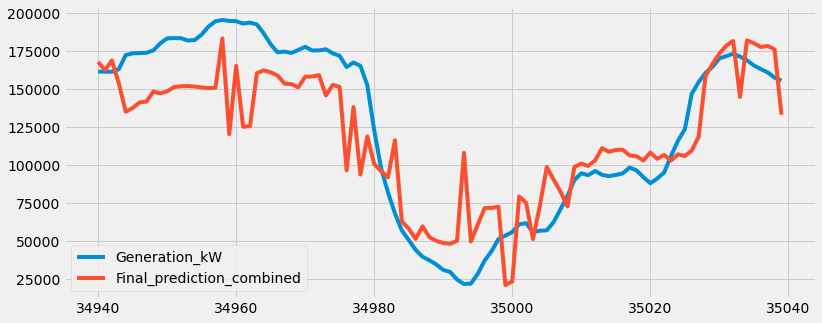

In [26]:
dataset_testing[['Generation_kW','Final_prediction_combined']].plot(figsize=(12,5),legend=True)

In [27]:
from sklearn.metrics import *

In [28]:
## printing evaluation metrics of 31st dec
print(mean_absolute_error(dataset_testing['Generation_kW'],dataset_testing['Final_prediction_combined']))
print(mean_squared_error(dataset_testing['Generation_kW'],dataset_testing['Final_prediction_combined']))
print(np.sqrt(mean_squared_error(dataset_testing['Generation_kW'],dataset_testing['Final_prediction_combined'])))

23102.843371162508
813369351.0584171
28519.6309768976


In [ ]:
## 23102.843371162508
## 813369351.0584171
## 28519.6309768976